__Group 20__:
- __Inês Rocha 20220052@novaims.unl.pt__
- __Pedro Ferreira 20220589@novaims.unl.pt__
- __Quintino Fernandes 20220634@novaims.unl.pt__

__Dataset__: https://drive.google.com/drive/folders/1NJOCRQ3ynA4BEOvWj5Ypr6iwi108LfOh?usp=share_link

(This is the non-zipped version, so one can see the images themselves. For the notebook, we use a zipped version, whose link is in the cell where the folder is imported. This is the dataset that we import to the model notebook, so it already has transformations that are made in preprocessing).

__Summary of the notebook:__

- We check some of the base characteristics of the dataset. We have an image-only dataset whose labels are right below the beginning of the second section (7 classes).

- We check the format of the targets and the tensorflow image dataset.

- When checking the distribution of data around all the classes, we see that one is a vast majority of the dataset. So, we conclude we have a heavily imbalanced dataset.

- We check some images of the dataset, so we have an idea how they are taken, which will help in the preprocessing stage.

- We also check for duplicates using the difPy package. We conclude that there are only two duplicates, so it is irrelevant, as we will later, in the preprocessing stage, duplicate images anyways.

__The problem__: We have a dataset with around 10000 photo images of skin marks in humans. They are all labeled as a type of cancer, so our objective is to train a neural network and improve it to the point where it can distinguish from the various types of cancer, as accurately as it can. To do so, we will try some variations of a particular neural network architecture (the residual neural network), changing some things to try to adapt a neural network to our specific problem.


__References__:
__References:__
1. [Algorithms for Skin Cancer Classification from Dermoscopic Images (2022)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8945332/)
2. [Skin Cancer Classification from Dermoscopic Images: A Systematic Review (2022)](https://www.mdpi.com/1999-4893/15/11/438)
3. [Skin Cancer Classification: A Systematic Review (2022)](https://www.frontiersin.org/articles/10.3389/fonc.2022.893972/full)
4.[KerasTuner](https://keras.io/guides/keras_tuner/getting_started/)
4. [Finding Duplicate Images with Python (2021), by Elise Landman](https://towardsdatascience.com/finding-duplicate-images-with-python-71c04ec8051)
5. [difPy Guide](https://difpy.readthedocs.io/en/latest/)


# 1. Import the dataset

We begin by installing and importing the necessary libraries

In [ ]:
pip install difPy

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras.preprocessing import image_dataset_from_directory

import os
import shutil
import random 
import zipfile

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap
from difPy import dif

# from sklearn.model_selection import train_test_split

import gdown

We upload the zip file with our Skin Cancer dataset (HAM10000)

In [ ]:
url = 'https://drive.google.com/uc?id=18qlxVc-a5hDkcWqsmjMmhTqcb9-H0ol0'
output = 'data.zip'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=18qlxVc-a5hDkcWqsmjMmhTqcb9-H0ol0
To: /content/data.zip
100%|██████████| 2.77G/2.77G [00:22<00:00, 123MB/s]


'data.zip'

In this cell we extract the files from the data.zip file and loading into this workbook filesystem. 

In [ ]:
zip_ = zipfile.ZipFile('data.zip')
zip_.extractall()
zip_.close()
path = ""

In this cell we extract the files from the data.zip file and loading into the notebook filesystem. 

In [ ]:
training_folder, val_folder, testing_folder = "/content/HAM10000_images/train/", "/content/HAM10000_images/val/", "/content/HAM10000_images/test/"

In [ ]:
image_size=(256,256)
crop_to_aspect_ratio=True
color_mode='rgb'
batch_size=64
label_mode="categorical"
shuffle=True
seed=0

We defined the **image size** for our dataset to be **128x128 pixels**, because its a standart measure for iamges and so that images with diferent shapes dont conflict with our models. 

Our label mode is categorical, since our optimization problem is to define which type of skin cancer does.

In [ ]:
# Generate an object of type tf.data.Dataset 
ds_train = image_dataset_from_directory(training_folder, 
                                                image_size=image_size,
                                                crop_to_aspect_ratio=crop_to_aspect_ratio,
                                                color_mode=color_mode,
                                                batch_size=batch_size,
                                                label_mode=label_mode, 
                                                shuffle=shuffle,
                                                seed=seed)

Found 6809 files belonging to 7 classes.


In [ ]:
ds_val = image_dataset_from_directory(val_folder, 
                                       image_size=image_size,
                                       crop_to_aspect_ratio=crop_to_aspect_ratio,
                                       color_mode=color_mode,
                                       batch_size=batch_size,
                                       label_mode=label_mode,                                     
                                       shuffle=shuffle,
                                       seed=seed)

Found 1703 files belonging to 7 classes.


In [ ]:
ds_test = image_dataset_from_directory(testing_folder, 
                                       image_size=image_size,
                                       crop_to_aspect_ratio=crop_to_aspect_ratio,
                                       color_mode=color_mode,
                                       batch_size=batch_size,
                                       label_mode=label_mode,                                     
                                       shuffle=shuffle,
                                       seed=seed)

Found 1503 files belonging to 7 classes.


After the creation of the ds_train/test/val datasets we can confirm that the function read all the files for each folder.

# 2. Exploration

First, here is a legend of what exactly the target names stand for:
- "akiec": actinic keratoses and intraepithelial carcinoma / Bowen's disease
- "bcc": basal cell carcinoma
- "bkl": benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses)
- "df": dermatofibroma
- "mel": melanoma
- "nv": melanocytic nevi
- "vasc": vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc)


Let's check the shapes of the data and how it is structured.

In [ ]:
iter_train = iter(ds_train)
batch_x_train, batch_y_train = iter_train.next()

print(f"Data shape: {batch_x_train.shape}",
      f"\nTarget shape: {batch_y_train.shape}")

print("\nSample of x_train:", batch_x_train[0, 0:3, 0:3, 0])

print("\nSample of y_train:", batch_y_train[0:5])

print("Sample average of y_train:", tf.reduce_mean(batch_y_train))

Data shape: (64, 256, 256, 3) 
Target shape: (64, 7)

Sample of x_train: tf.Tensor(
[[137.23534 139.77837 138.90324]
 [135.43071 140.72656 137.79118]
 [136.3134  140.88011 141.77794]], shape=(3, 3), dtype=float32)

Sample of y_train: tf.Tensor(
[[0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0.]], shape=(5, 7), dtype=float32)
Sample average of y_train: tf.Tensor(0.14285715, shape=(), dtype=float32)


We can see that we have a batch of 64 images, where each one is 256x256 and has 3 color channels. The target has the same number of instances, but we can see it has 7 different classes. Then we see the first square of 2x2 pixels' values, to then see how the first 5 instances are classified. It is a vector where there is a 1 in the corresponding image category.

We want to see how imbalanced the classes are, so in the next cell we will check the numbers for every subset.

Nº of instances in classes ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'] for the TRAIN set: [222, 350, 747, 78, 757, 4559, 96]
Proportion of instances in classes ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'] for the TRAIN set in %: [3.3, 5.1, 11.0, 1.1, 11.1, 66.9, 1.4]

Nº of instances in classes ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'] for the TEST set: [49, 77, 165, 17, 167, 1006, 22]
Proportion of instances in classes ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'] for the TEST set in %: [3.3, 5.1, 11.0, 1.1, 11.1, 66.9, 1.5]

Nº of instances in classes ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'] for the VALIDATION set: [56, 87, 187, 20, 189, 1140, 24]
Proportion of instances in classes ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'] for the VALIDATION set in %: [3.3, 5.1, 11.0, 1.2, 11.1, 66.9, 1.4]



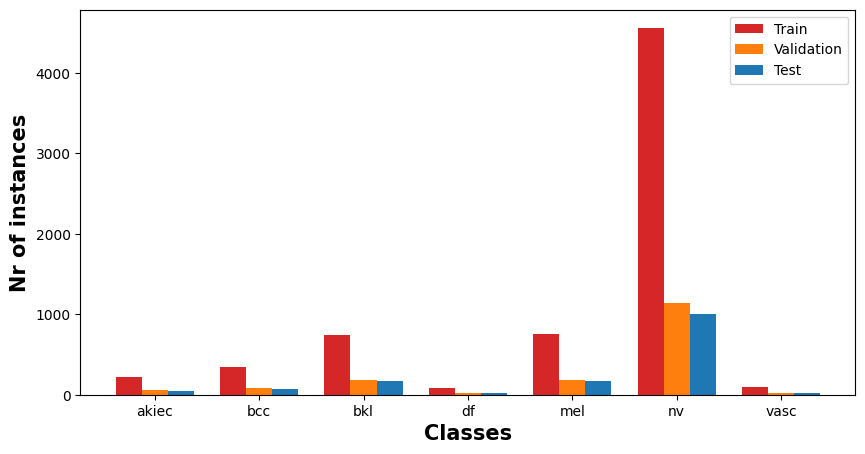

In [ ]:
instances_train = []
instances_val = []
instances_test = []
prop_train = []
prop_val = []
prop_test = []

for split in [training_folder, val_folder, testing_folder]:
    for c in ds_train.class_names:
        n_train_c = len(os.listdir(split + f"/{c}"))

        if split == training_folder:
          total = 6810
          instances_train.append(n_train_c)
          prop_train.append(round(n_train_c*100/total,1))
        elif split == val_folder:
          total = 1703
          instances_val.append(n_train_c)
          prop_val.append(round(n_train_c*100/total,1))
        else:
          total = 1503
          instances_test.append(n_train_c)
          prop_test.append(round(n_train_c*100/total,1))

print(f"Nº of instances in classes {ds_train.class_names} for the TRAIN set: {instances_train}")
print(f"Proportion of instances in classes {ds_train.class_names} for the TRAIN set in %: {prop_train}\n")

print(f"Nº of instances in classes {ds_train.class_names} for the TEST set: {instances_test}")
print(f"Proportion of instances in classes {ds_train.class_names} for the TEST set in %: {prop_test}\n")

print(f"Nº of instances in classes {ds_train.class_names} for the VALIDATION set: {instances_val}")
print(f"Proportion of instances in classes {ds_train.class_names} for the VALIDATION set in %: {prop_val}\n")

barWidth = 0.25
fig = plt.subplots(figsize =(10,5)) 


# Set position of bar on X axis
br1 = np.arange(len(instances_train))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, instances_train, color ='tab:red', width = barWidth, label ='Train')
plt.bar(br2, instances_val, color ='tab:orange', width = barWidth, label ='Validation')
plt.bar(br3, instances_test, color ='tab:blue', width = barWidth,label ='Test')
 
# Adding Xticks
plt.xlabel('Classes', fontweight ='bold', fontsize = 15)
plt.ylabel('Nr of instances', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(instances_train))],
        ds_train.class_names)
 
plt.legend()
plt.show()

It seems like it is very imbalanced in terms of having too many "nv" images. We have to be very careful when we evaluate the models, because it will probably favor the prediction of that class. It is stratified, so the proportion related to the total number of instances is more or less the same for the train, validation and test. We may have to use some oversampling techniques later, in the preprocessing.

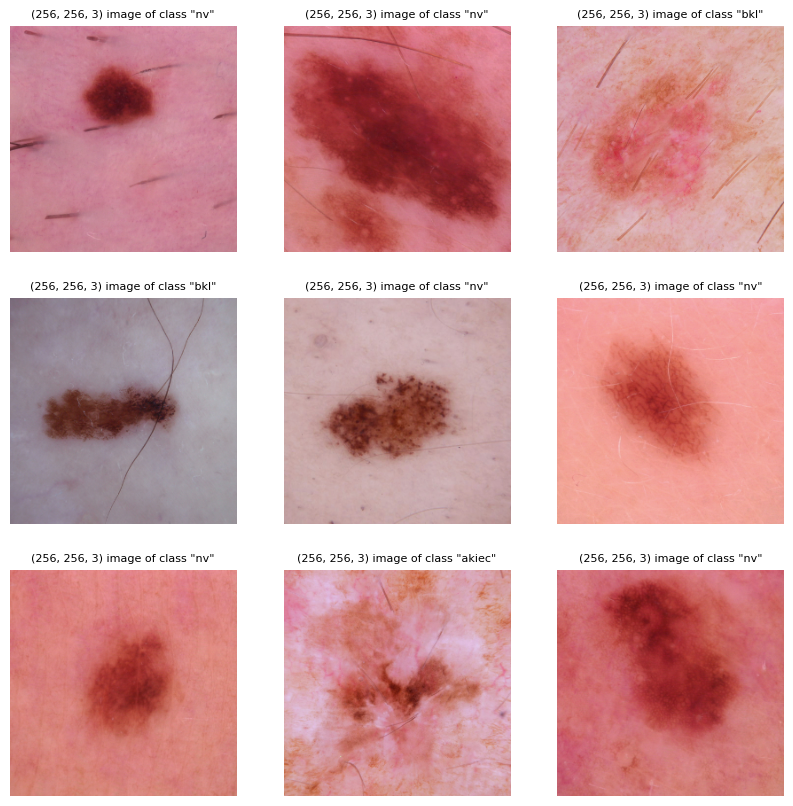

In [ ]:
def show_sample_batch(ds, grid_size=(3, 3)):
    n_images = grid_size[0]*grid_size[1]
    # Get a batch via iteration
    iter_ = iter(ds)
    batch_x, batch_y = iter_.next()
    batch_x, batch_y = batch_x[0:n_images], batch_y[0:n_images]
    # Plot the images
    plt.figure(figsize=(10, 10))
    for i, (img, y) in enumerate(zip(batch_x, batch_y)):
        ax = plt.subplot(grid_size[0], grid_size[1],  i + 1)
        plt.imshow(tf.cast(img, tf.int32))

        for j in range(len(y)):
          # We want to show the actual name of the class instead of a vector:
          if y[j] == 1:
            name = ds_train.class_names[j]
        plt.title("{} image of class \"{}\"".format(img.shape, name), size=8)
        plt.axis("off")

show_sample_batch(ds_train)

Above we can see some images of the dataset.

Now we want to know if there are any duplicate images in the dataset. Takes a while to run, so be careful.

Here we used the difPy library to compare pixel by pixel if an image is equal to any other in the dataset, hence checking if we have any duplicates in thsi dataset.

In [ ]:
search = dif(["/content/train","/content/test"], show_progress=True)

difPy preparing files: [10015/10015] [100%]
difPy comparing images: [10015/10015] [100%]
Found 2 pair(s) of duplicate image(s) in 14115.7228 seconds.


In [ ]:
search.result

{103836020477070940366442196641784160230: {'location': '/content/test/nv/ISIC_0029938.jpg',
  'matches': {250057867559035988572316430591838905250: {'location': '/content/train/nv/ISIC_0024777.jpg',
    'mse': 0.0}}},
 246450701985485140509045825924283795684: {'location': '/content/train/nv/ISIC_0024366.jpg',
  'matches': {270888283782101699752043880473364158097: {'location': '/content/train/nv/ISIC_0029861.jpg',
    'mse': 0.0}}}}

As we can see above, we found only two pairs of duplicate images, which is really not significant and in the next notebook we will do copies of images, to compensate data imbalance. We wanted to know if there was a big number of repeated records, but it wasn't the case.